<a href="https://colab.research.google.com/github/Krishnan9074/.0/blob/master/recommendations_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Step 0: Load Packages and Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer

import os
from scipy.sparse import coo_matrix

# Step 1: Data Loading and Preprocessing

In [ ]:
# Read your dataset (replace 'marketing_sample_for_walmart_com-walmart_com_product_review__20200701_20201231__5k_data.tsv' with your dataset path)
train_data = pd.read_csv('marketing_sample_for_walmart_com-walmart_com_product_review__20200701_20201231__5k_data.tsv', sep='\t')
train_data.columns

Index(['Uniq Id', 'Crawl Timestamp', 'Dataset Origin', 'Product Id',
       'Product Barcode', 'Product Company Type Source',
       'Product Brand Source', 'Product Brand Normalised Source',
       'Product Name Source', 'Match Rank', 'Match Score', 'Match Type',
       'Retailer', 'Product Category', 'Product Brand', 'Product Name',
       'Product Price', 'Sku', 'Upc', 'Product Url', 'Market',
       'Product Description', 'Product Currency',
       'Product Available Inventory', 'Product Image Url',
       'Product Model Number', 'Product Tags', 'Product Contents',
       'Product Rating', 'Product Reviews Count', 'Bsr', 'Joining Key'],
      dtype='object')

In [ ]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 32 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Uniq Id                          5000 non-null   object 
 1   Crawl Timestamp                  5000 non-null   object 
 2   Dataset Origin                   0 non-null      float64
 3   Product Id                       5000 non-null   object 
 4   Product Barcode                  0 non-null      float64
 5   Product Company Type Source      5000 non-null   object 
 6   Product Brand Source             139 non-null    object 
 7   Product Brand Normalised Source  139 non-null    object 
 8   Product Name Source              139 non-null    object 
 9   Match Rank                       0 non-null      float64
 10  Match Score                      0 non-null      float64
 11  Match Type                       0 non-null      float64
 12  Retailer            

In [ ]:
train_data = train_data[['Uniq Id','Product Id', 'Product Rating', 'Product Reviews Count', 'Product Category', 'Product Brand', 'Product Name', 'Product Image Url', 'Product Description', 'Product Tags']]
train_data.head(3)

,Uniq Id,Product Id,Product Rating,Product Reviews Count,Product Category,Product Brand,Product Name,Product Image Url,Product Description,Product Tags
0,1705736792d82aa2f2d3caf1c07c53f4,2e17bf4acecdece67fc00f07ad62c910,NaN,NaN,Premium Beauty > Premium Makeup > Premium Nail...,OPI,"OPI Infinite Shine, Nail Lacquer Nail Polish, ...",https://i5.walmartimages.com/asr/0e1f4c51-c1a4...,NaN,"OPI Infinite Shine, Nail Lacquer Nail Polish, ..."
1,95a9fe6f4810fcfc7ff244fd06784f11,076e5854a62dd283c253d6bae415af1f,NaN,NaN,Beauty > Hair Care > Hair Color > Auburn Hair ...,Nice'n Easy,"Nice n Easy Permanent Color, 111 Natural Mediu...",https://i5.walmartimages.com/asr/9c8e42e4-13a5...,Pack of 3 Pack of 3 for the UPC: 381519000201 ...,"Nice 'n Easy Permanent Color, 111 Natural Medi..."
2,8d4d0330178d3ed181b15a4102b287f2,8a4fe5d9c7a6ed26cc44d785a454b124,4.5,29221.0,Beauty > Hair Care > Hair Color > Permanent Ha...,Clairol,Clairol Nice N Easy Permanent Color 7/106A Nat...,https://i5.walmartimages.com/asr/e3a601c2-6a2b...,This Clairol Nice N Easy Permanent Color gives...,Clairol Nice 'N Easy Permanent Color 7/106A Na...


# Basic Operations

In [ ]:
train_data['Product Tags']

,Product Tags
0,"OPI Infinite Shine, Nail Lacquer Nail Polish, ..."
1,"Nice 'n Easy Permanent Color, 111 Natural Medi..."
2,Clairol Nice 'N Easy Permanent Color 7/106A Na...
3,"Kokie Professional Matte Lipstick, Hot Berry, ..."
4,"Gillette TRAC II Plus Razor Blade Refills, Fit..."
...,...
4902,"Dove Refresh+Care Detox & Purify Dry Shampoo, ..."
4903,Ivory Gentle Aluminum Free Deodorant Hint of A...
4904,($66 Value) Oxygenetix Oxygenating Liquid Foun...
4905,"Colgate Sensitive Toothpaste, Multiprotection ..."


In [ ]:
train_data.shape

(4907, 10)

In [ ]:
train_data.isnull().sum()

,0
Uniq Id,0
Product Id,0
Product Rating,2746
Product Reviews Count,1610
Product Category,10
Product Brand,13
Product Name,0
Product Image Url,1
Product Description,1104
Product Tags,1


In [ ]:
# Fill missing values in 'Product Rating' with a default value (e.g., 0)
train_data['Product Rating'].fillna(0, inplace=True)
# Fill missing values in 'Product Reviews Count' with a default value (e.g., 0)
train_data['Product Reviews Count'].fillna(0, inplace=True)
# Fill missing values in 'Product Category' with a default value (e.g., 'Unknown')
train_data['Product Category'].fillna('', inplace=True)
# Fill missing values in 'Product Brand' with a default value (e.g., 'Unknown')
train_data['Product Brand'].fillna('', inplace=True)
# Fill missing values in 'Product Description' with an empty string
train_data['Product Description'].fillna('', inplace=True)

In [ ]:
train_data.isnull().sum()

,0
Uniq Id,0
Product Id,0
Product Rating,0
Product Reviews Count,0
Product Category,0
Product Brand,0
Product Name,0
Product Image Url,1
Product Description,0
Product Tags,1


In [ ]:
train_data.duplicated().sum()

0

In [ ]:
# make columns shorter
# Define the mapping of current column names to shorter names
column_name_mapping = {
    'Uniq Id': 'ID',
    'Product Id': 'ProdID',
    'Product Rating': 'Rating',
    'Product Reviews Count': 'ReviewCount',
    'Product Category': 'Category',
    'Product Brand': 'Brand',
    'Product Name': 'Name',
    'Product Image Url': 'ImageURL',
    'Product Description': 'Description',
    'Product Tags': 'Tags',
    'Product Contents': 'Contents'
}
# Rename the columns using the mapping
train_data.rename(columns=column_name_mapping, inplace=True)

In [ ]:
train_data['ID'] = train_data['ID'].str.extract(r'(\d+)').astype(float)
train_data['ProdID'] = train_data['ProdID'].str.extract(r'(\d+)').astype(float)

# Step 2: EDA (Exploratory Data Analysis)

In [ ]:
# Basic statistics
num_users = train_data['ID'].nunique()
num_items = train_data['ProdID'].nunique()
num_ratings = train_data['Rating'].nunique()
print(f"Number of unique users: {num_users}")
print(f"Number of unique items: {num_items}")
print(f"Number of unique ratings: {num_ratings}")

Number of unique users: 1692
Number of unique items: 1676
Number of unique ratings: 36


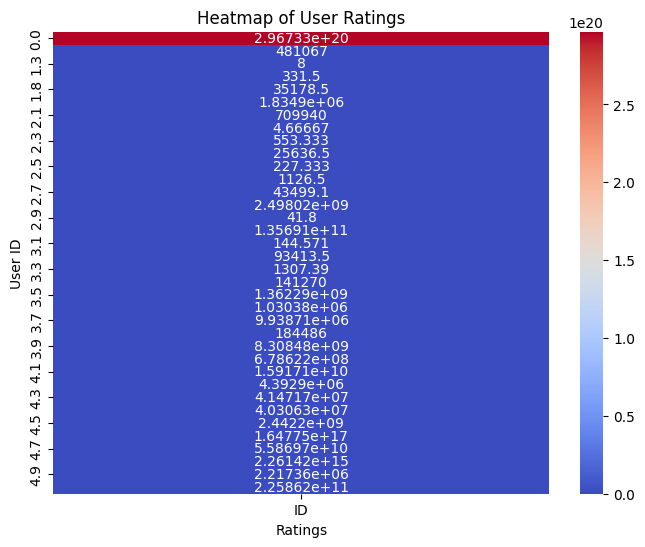

In [ ]:
# Pivot the DataFrame to create a heatmap
heatmap_data = train_data.pivot_table('ID', 'Rating')

# Create the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(heatmap_data, annot=True, fmt='g', cmap='coolwarm', cbar=True)
plt.title('Heatmap of User Ratings')
plt.xlabel('Ratings')
plt.ylabel('User ID')
plt.show()

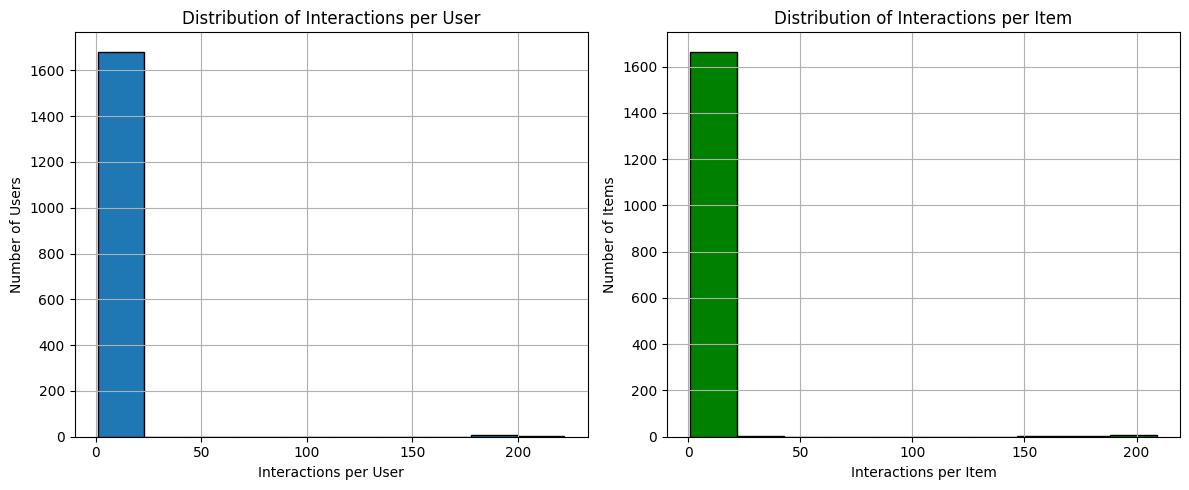

In [ ]:
# Distribution of interactions
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
train_data['ID'].value_counts().hist(bins=10, edgecolor='k')
plt.xlabel('Interactions per User')
plt.ylabel('Number of Users')
plt.title('Distribution of Interactions per User')

plt.subplot(1, 2, 2)
train_data['ProdID'].value_counts().hist(bins=10, edgecolor='k',color='green')
plt.xlabel('Interactions per Item')
plt.ylabel('Number of Items')
plt.title('Distribution of Interactions per Item')

plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Most Popular items')

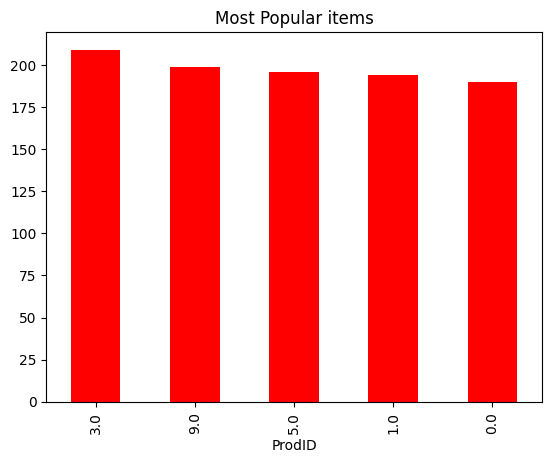

In [ ]:
# Most popular items
popular_items = train_data['ProdID'].value_counts().head(5)
popular_items.plot(kind='bar',color='red')
plt.title("Most Popular items")

<Axes: xlabel='Rating'>

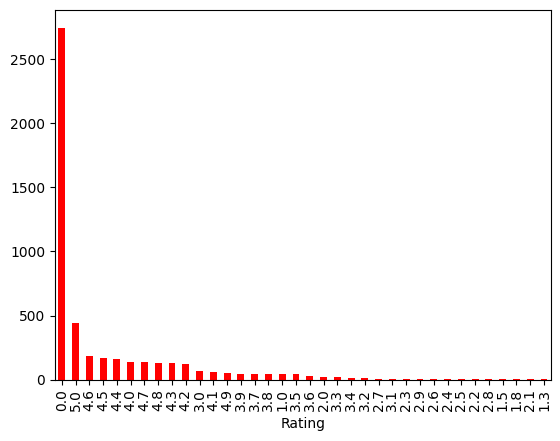

In [ ]:
# most rated counts
train_data['Rating'].value_counts().plot(kind='bar',color='red')

# Step 3: Data Cleaning and Tags Creations

In [ ]:
import spacy
from spacy.lang.en.stop_words import STOP_WORDS

nlp = spacy.load("en_core_web_sm")

def clean_and_extract_tags(text):
    doc = nlp(text.lower())
    tags = [token.text for token in doc if token.text.isalnum() and token.text not in STOP_WORDS]
    return ', '.join(tags)

columns_to_extract_tags_from = ['Category', 'Brand', 'Description']

for column in columns_to_extract_tags_from:
    train_data[column] = train_data[column].apply(clean_and_extract_tags)

In [ ]:
# Concatenate the cleaned tags from all relevant columns
train_data['Tags'] = train_data[columns_to_extract_tags_from].apply(lambda row: ', '.join(row), axis=1)

# Rating Base Recommendations System

In [ ]:
average_ratings = train_data.groupby(['Name','ReviewCount','Brand','ImageURL'])['Rating'].mean().reset_index()

In [ ]:
top_rated_items = average_ratings.sort_values(by='Rating', ascending=False)

rating_base_recommendation = top_rated_items.head(10)

In [ ]:
rating_base_recommendation['Rating'] = rating_base_recommendation['Rating'].astype(int)
rating_base_recommendation['ReviewCount'] = rating_base_recommendation['ReviewCount'].astype(int)

<ipython-input-22-14a31ed65ba8>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rating_base_recommendation['Rating'] = rating_base_recommendation['Rating'].astype(int)
<ipython-input-22-14a31ed65ba8>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rating_base_recommendation['ReviewCount'] = rating_base_recommendation['ReviewCount'].astype(int)


In [ ]:
print("Rating Base Recommendation System: (Trending Products)")
rating_base_recommendation[['Name','Rating','ReviewCount','Brand','ImageURL']] = rating_base_recommendation[['Name','Rating','ReviewCount','Brand','ImageURL']]
rating_base_recommendation

Rating Base Recommendation System: (Trending Products)


<ipython-input-23-6e413a8a573d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rating_base_recommendation[['Name','Rating','ReviewCount','Brand','ImageURL']] = rating_base_recommendation[['Name','Rating','ReviewCount','Brand','ImageURL']]


,Name,ReviewCount,Brand,ImageURL,Rating
1225,Clinique Take the Day Off Makeup Remover 5.1oz...,1,clinique,https://i5.walmartimages.com/asr/3b668007-5cc8...,5
2225,"JM Products Isoplus Spritz, 10 oz",1,isoplus,https://i5.walmartimages.com/asr/87aed1e4-4a8f...,5
2250,Jergens Original Scent Dry Skin Moisturizer 3 oz,3,jergens,https://i5.walmartimages.com/asr/21881abc-003d...,5
2249,Jergens Natural Glow Instant Sun Sunless Tanni...,3,jergens,https://i5.walmartimages.com/asr/5cc25b9b-1b5e...,5
3656,"Poo~Pourri Before-You-Go Toilet Spray, Secret ...",1,"poo, pourri",https://i5.walmartimages.com/asr/0af2a86e-5e1f...,5
543,Almay Pure Blends Eyeshadow,1,almay,https://i5.walmartimages.com/asr/05a2fa58-3d41...,5
2230,"Jack Black Beard Lube Conditioning Shave, Shav...",2,"jack, black",https://i5.walmartimages.com/asr/9c7b91b5-9fb8...,5
4601,Vaseline Cocoa Butter Deep Conditioning Body L...,1,vaseline,https://i5.walmartimages.com/asr/5168f814-3992...,5
3662,"Prell Shampoo, Classic Clean 13.50 oz (Pack of 4)",8,prell,https://i5.walmartimages.com/asr/591617a5-4b84...,5
3664,Premium Ginger Detox Foot Pads Patch Organic H...,1,unbrand,https://i5.walmartimages.com/asr/4affeec5-52bd...,5


# Content Base Recommendation system (User Preferences or Items similarities)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

tfidf_vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix_content = tfidf_vectorizer.fit_transform(train_data['Tags'])
cosine_similarities_content = cosine_similarity(tfidf_matrix_content,tfidf_matrix_content)

In [ ]:
item_name = 'OPI Infinite Shine, Nail Lacquer Nail Polish, Bubble Bath'
item_index = train_data[train_data['Name']==item_name].index[0]

In [ ]:
similar_items = list(enumerate(cosine_similarities_content[item_index]))

In [ ]:
similar_items = sorted(similar_items, key=lambda x:x[1], reverse=True)
top_similar_items = similar_items[1:10]

recommended_items_indics = [x[0] for x in top_similar_items]

In [ ]:
train_data.iloc[recommended_items_indics][['Name','ReviewCount','Brand']]

,Name,ReviewCount,Brand
156,OPI Nail Lacquer Polish .5oz/15mL - This Gown ...,0.0,opi
184,OPI Nail Gel Polish GelColor .5oz/15mL 3 CT Co...,0.0,opi
205,OPI Nail Lacquer - Dont Bossa Nova Me Around -...,0.0,opi
237,OPI Infinite Shine 2 Polish - ISL P33 - Alpaca...,5.0,opi
325,OPI Gel Polish Fall 2019 Scotland Collection G...,1.0,opi
375,OPI Nail Gel Polish GelColor .5oz/15mL 3 CT Co...,1.0,opi
402,"OPI Nail Polish, Strawberry Margarita, 0.5 Fl Oz",57.0,opi
706,OPI Nail Gel Polish GelColor .5oz/15mL 3 CT Co...,1.0,opi
886,OPI- Nail Lacquer-GelColor - &quotLiv&quotin t...,0.0,opi


# Function To Recommend Products for Content Base

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

def content_based_recommendations(train_data, item_name, top_n=10):
    # Check if the item name exists in the training data
    if item_name not in train_data['Name'].values:
        print(f"Item '{item_name}' not found in the training data.")
        return pd.DataFrame()

    # Create a TF-IDF vectorizer for item descriptions
    tfidf_vectorizer = TfidfVectorizer(stop_words='english')

    # Apply TF-IDF vectorization to item descriptions
    tfidf_matrix_content = tfidf_vectorizer.fit_transform(train_data['Tags'])

    # Calculate cosine similarity between items based on descriptions
    cosine_similarities_content = cosine_similarity(tfidf_matrix_content, tfidf_matrix_content)

    # Find the index of the item
    item_index = train_data[train_data['Name'] == item_name].index[0]

    # Get the cosine similarity scores for the item
    similar_items = list(enumerate(cosine_similarities_content[item_index]))

    # Sort similar items by similarity score in descending order
    similar_items = sorted(similar_items, key=lambda x: x[1], reverse=True)

    # Get the top N most similar items (excluding the item itself)
    top_similar_items = similar_items[1:top_n+1]

    # Get the indices of the top similar items
    recommended_item_indices = [x[0] for x in top_similar_items]

    # Get the details of the top similar items
    recommended_items_details = train_data.iloc[recommended_item_indices][['Name', 'ReviewCount', 'Brand', 'ImageURL', 'Rating']]

    return recommended_items_details

In [ ]:
# Example: Get content-based recommendations for a specific item
item_name = 'OPI Infinite Shine, Nail Lacquer Nail Polish, Bubble Bath'
content_based_rec = content_based_recommendations(train_data, item_name, top_n=8)

content_based_rec

,Name,ReviewCount,Brand,ImageURL,Rating
156,OPI Nail Lacquer Polish .5oz/15mL - This Gown ...,0.0,opi,https://i5.walmartimages.com/asr/71caed3f-5f83...,0.0
184,OPI Nail Gel Polish GelColor .5oz/15mL 3 CT Co...,0.0,opi,https://i5.walmartimages.com/asr/2d6f5147-53a8...,0.0
205,OPI Nail Lacquer - Dont Bossa Nova Me Around -...,0.0,opi,https://i5.walmartimages.com/asr/fd1195d2-8d8d...,0.0
237,OPI Infinite Shine 2 Polish - ISL P33 - Alpaca...,5.0,opi,https://i5.walmartimages.com/asr/7426eb5c-1690...,0.0
325,OPI Gel Polish Fall 2019 Scotland Collection G...,1.0,opi,https://i5.walmartimages.com/asr/79bbbd9f-9a89...,0.0
375,OPI Nail Gel Polish GelColor .5oz/15mL 3 CT Co...,1.0,opi,https://i5.walmartimages.com/asr/744e869c-3500...,5.0
402,"OPI Nail Polish, Strawberry Margarita, 0.5 Fl Oz",57.0,opi,https://i5.walmartimages.com/asr/b95676e5-96ab...,4.4
706,OPI Nail Gel Polish GelColor .5oz/15mL 3 CT Co...,1.0,opi,https://i5.walmartimages.com/asr/c7ba4815-52f7...,5.0


In [ ]:
# Example: Get content-based recommendations for a specific item
item_name = 'Kokie Professional Matte Lipstick, Hot Berry, 0.14 fl oz'
content_based_rec = content_based_recommendations(train_data, item_name, top_n=8)

content_based_rec

,Name,ReviewCount,Brand,ImageURL,Rating
3406,"Kokie Professional Matte Lipstick, Firecracker...",0.0,"kokie, cosmetics",https://i5.walmartimages.com/asr/8312221b-ed22...,0.0
546,"Kokie Professional Matte Lipstick, Kiss Me, 0....",0.0,"kokie, cosmetics",https://i5.walmartimages.com/asr/27dd82a2-2b9c...,0.0
2406,"L.A. Colors Matte Lipstick, Tender Matte",3.0,colors,https://i5.walmartimages.com/asr/271264fb-e8c3...,3.7
4050,Kokie Professional Lip Poudre Liquid Matte Liq...,7.0,"kokie, cosmetics",https://i5.walmartimages.com/asr/fdd7498c-319f...,3.4
4084,e.l.f. Mad for Matte 4 Piece Lip Color Set,0.0,cosmetics,https://i5.walmartimages.com/asr/e2d30304-edc9...,0.0
1559,"LOreal Paris Colour Riche Matte Lip Liner, Mat...",495.0,paris,https://i5.walmartimages.com/asr/baf97085-7231...,4.4
2873,Kokie Professional Lip Poudre Liquid Matte Liq...,7.0,"kokie, cosmetics",https://i5.walmartimages.com/asr/31c99d9b-ea11...,3.4
3023,Be Matte Lipstick - Pink,2.0,"city, color",https://i5.walmartimages.com/asr/4425a13e-085f...,3.0


# Collaborative Filtering (User Item Similarity)

In [ ]:
user_item_matrix = train_data.pivot_table(index='ID', columns='ProdID', values='Rating',aggfunc='mean').fillna(0).astype(int)

In [ ]:
user_similarity = cosine_similarity(user_item_matrix)

In [ ]:
target_user_id = 4
target_user_index = user_item_matrix.index.get_loc(target_user_id)

In [ ]:
user_similarities = user_similarity[target_user_index]

similar_user_indices = user_similarities.argsort()[::-1][1:]

In [ ]:
recommend_items = []

for user_index in similar_user_indices:
    rated_by_similar_user = user_item_matrix.iloc[user_index]
    not_rated_by_target_user = (rated_by_similar_user==0) & (user_item_matrix.iloc[target_user_index]==0)

    recommend_items.extend(user_item_matrix.columns[not_rated_by_target_user][:10])

recommended_items_details = train_data[train_data['ProdID'].isin(recommend_items)][['Name','ReviewCount','Brand','ImageURL','Rating']]

In [ ]:
recommended_items_details.head(10)

,Name,ReviewCount,Brand,ImageURL,Rating
15,Clairol Natural Instincts Demi-Permanent Hair ...,2935.0,clairol,https://i5.walmartimages.com/asr/00a6e54a-e431...,3.7
33,"DenTek Kids Fun Flossers, Removes Food & Plaqu...",3.0,dentek,https://i5.walmartimages.com/asr/de6e52eb-6e18...,0.0
61,"COVERGIRL Exhibitionist Cream Lipstick, 395 Da...",713.0,covergirl,https://i5.walmartimages.com/asr/95076ec0-ffbd...,4.3
64,Neutrogena SkinClearing Oil-Free Liquid Founda...,741.0,neutrogena,https://i5.walmartimages.com/asr/fd4d78d8-310a...,4.2
69,Design Essentials Natural Coconut & Monoi Curl...,1.0,"design, essentials",https://i5.walmartimages.com/asr/ff2dba1d-0c02...,5.0
78,"Paul Sebastian Fine Cologne Spray, Cologne for...",28.0,"paul, sebastian",https://i5.walmartimages.com/asr/03d08a07-18d7...,4.8
85,"BioAstin Hawaiian Astaxanthin, Vegan, 12mg, 75 Ct",3.0,bioastin,https://i5.walmartimages.com/asr/6da9e238-b19e...,5.0
92,"Bytewise Organic Moringa Leaf Powder, 12 Oz",0.0,bytewise,https://i5.walmartimages.com/asr/076f2b3f-fdc3...,0.0
94,Ag Hair Cosmetics Ultradynamics Extra-Firm Fin...,0.0,"ag, hair",https://i5.walmartimages.com/asr/5d217d98-a385...,0.0
108,OPI Nail Dipping Powder Perfection Combo - Liq...,1.0,opi,https://i5.walmartimages.com/asr/ef1607ee-5bdb...,3.0


# Function That Recommend Items

In [ ]:
def collaborative_filtering_recommendations(train_data, target_user_id, top_n=10):
    # Create the user-item matrix
    user_item_matrix = train_data.pivot_table(index='ID', columns='ProdID', values='Rating', aggfunc='mean').fillna(0)

    # Calculate the user similarity matrix using cosine similarity
    user_similarity = cosine_similarity(user_item_matrix)

    # Find the index of the target user in the matrix
    target_user_index = user_item_matrix.index.get_loc(target_user_id)

    # Get the similarity scores for the target user
    user_similarities = user_similarity[target_user_index]

    # Sort the users by similarity in descending order (excluding the target user)
    similar_users_indices = user_similarities.argsort()[::-1][1:]

    # Generate recommendations based on similar users
    recommended_items = []

    for user_index in similar_users_indices:
        # Get items rated by the similar user but not by the target user
        rated_by_similar_user = user_item_matrix.iloc[user_index]
        not_rated_by_target_user = (rated_by_similar_user == 0) & (user_item_matrix.iloc[target_user_index] == 0)

        # Extract the item IDs of recommended items
        recommended_items.extend(user_item_matrix.columns[not_rated_by_target_user][:top_n])

    # Get the details of recommended items
    recommended_items_details = train_data[train_data['ProdID'].isin(recommended_items)][['Name', 'ReviewCount', 'Brand', 'ImageURL', 'Rating']]

    return recommended_items_details.head(10)

# Example usage
target_user_id = 4
top_n = 5
collaborative_filtering_rec = collaborative_filtering_recommendations(train_data, target_user_id)
print(f"Top {top_n} recommendations for User {target_user_id}:")
collaborative_filtering_rec

Top 5 recommendations for User 4:


,Name,ReviewCount,Brand,ImageURL,Rating
61,"COVERGIRL Exhibitionist Cream Lipstick, 395 Da...",713.0,covergirl,https://i5.walmartimages.com/asr/95076ec0-ffbd...,4.3
85,"BioAstin Hawaiian Astaxanthin, Vegan, 12mg, 75 Ct",3.0,bioastin,https://i5.walmartimages.com/asr/6da9e238-b19e...,5.0
86,LOreal Paris Feria Multi-Faceted Shimmering Pe...,2144.0,paris,https://i5.walmartimages.com/asr/c229026a-2b75...,3.1
108,OPI Nail Dipping Powder Perfection Combo - Liq...,1.0,opi,https://i5.walmartimages.com/asr/ef1607ee-5bdb...,3.0
144,Covidien Curity Maternity Pad Heavy 4.33&quot ...,0.0,covidien,https://i5.walmartimages.com/asr/e4e38217-ed43...,0.0
155,"Crest 3D White Brilliance Mouthwash, Alcohol F...",63.0,crest,https://i5.walmartimages.com/asr/1fcc5525-9ae3...,0.0
174,COVERGIRL Outlast All-Day Moisturizing Lip Col...,36.0,covergirl,https://i5.walmartimages.com/asr/4479896f-c6c4...,0.0
193,"Revlon ColorStay Skinny Liquid Liner, 304 Gree...",70.0,revlon,https://i5.walmartimages.com/asr/aa3b20a6-3d6d...,4.5
212,"Comvita Certified UMF 20+ Manuka Honey, Raw & ...",0.0,comvita,https://i5.walmartimages.com/asr/3cdc1498-a2ac...,0.0
241,"Ahava Mens Mineral Hand Cream, 3.4 Oz",0.0,ahava,https://i5.walmartimages.com/asr/f74e4bb7-47d3...,0.0


# Hybrid Recommendations

In [ ]:
# Hybrid Recommendations (Combine Content-Based and Collaborative Filtering)
def hybrid_recommendations(train_data,target_user_id, item_name, top_n=10):
    # Get content-based recommendations
    content_based_rec = content_based_recommendations(train_data,item_name, top_n)

    # Get collaborative filtering recommendations
    collaborative_filtering_rec = collaborative_filtering_recommendations(train_data,target_user_id, top_n)

    # Merge and deduplicate the recommendations
    hybrid_rec = pd.concat([content_based_rec, collaborative_filtering_rec]).drop_duplicates()

    return hybrid_rec.head(10)

In [ ]:
# Example usage: Get hybrid recommendations for a specific user and item
target_user_id = 4 # Change this to the user_id you want recommendations for
item_name = "OPI Nail Lacquer Polish .5oz/15mL - This Gown Needs A Crown NL U11"  # Change this to the item name
hybrid_rec = hybrid_recommendations(train_data,target_user_id, item_name, top_n=10)

print(f"Top 10 Hybrid Recommendations for User {target_user_id} and Item '{item_name}':")
hybrid_rec

Top 10 Hybrid Recommendations for User 4 and Item 'OPI Nail Lacquer Polish .5oz/15mL - This Gown Needs A Crown NL U11':


,Name,ReviewCount,Brand,ImageURL,Rating
156,OPI Nail Lacquer Polish .5oz/15mL - This Gown ...,0.0,opi,https://i5.walmartimages.com/asr/71caed3f-5f83...,0.0
184,OPI Nail Gel Polish GelColor .5oz/15mL 3 CT Co...,0.0,opi,https://i5.walmartimages.com/asr/2d6f5147-53a8...,0.0
205,OPI Nail Lacquer - Dont Bossa Nova Me Around -...,0.0,opi,https://i5.walmartimages.com/asr/fd1195d2-8d8d...,0.0
237,OPI Infinite Shine 2 Polish - ISL P33 - Alpaca...,5.0,opi,https://i5.walmartimages.com/asr/7426eb5c-1690...,0.0
325,OPI Gel Polish Fall 2019 Scotland Collection G...,1.0,opi,https://i5.walmartimages.com/asr/79bbbd9f-9a89...,0.0
375,OPI Nail Gel Polish GelColor .5oz/15mL 3 CT Co...,1.0,opi,https://i5.walmartimages.com/asr/744e869c-3500...,5.0
402,"OPI Nail Polish, Strawberry Margarita, 0.5 Fl Oz",57.0,opi,https://i5.walmartimages.com/asr/b95676e5-96ab...,4.4
706,OPI Nail Gel Polish GelColor .5oz/15mL 3 CT Co...,1.0,opi,https://i5.walmartimages.com/asr/c7ba4815-52f7...,5.0
886,OPI- Nail Lacquer-GelColor - &quotLiv&quotin t...,0.0,opi,https://i5.walmartimages.com/asr/98b4194c-e026...,0.0
1042,"OPI GelColor Gel Nail Polish, Dulce De Leche, ...",1.0,opi,https://i5.walmartimages.com/asr/c1b2c370-b2d2...,0.0


In [ ]:
# Example usage: Get hybrid recommendations for a specific user and item
target_user_id = 10 # Change this to the user_id you want recommendations for
item_name = 'Black Radiance Perfect Tone Matte Lip Crème, Succulent Plum'

hybrid_rec = hybrid_recommendations(train_data,target_user_id, item_name, top_n=10)

print(f"Top 10 Hybrid Recommendations for User {target_user_id} and Item '{item_name}':")
hybrid_rec

Top 10 Hybrid Recommendations for User 10 and Item 'Black Radiance Perfect Tone Matte Lip Crème, Succulent Plum':


,Name,ReviewCount,Brand,ImageURL,Rating
896,"Black Radiance Perfect Tone Lip Color, Vintage...",78.0,"black, radiance",https://i5.walmartimages.com/asr/485f26b4-a19a...,4.7
2496,"Black Radiance Perfect Tone Lip Color, Hollywo...",18.0,"black, radiance",https://i5.walmartimages.com/asr/fe3da48f-5142...,4.3
3,"Kokie Professional Matte Lipstick, Hot Berry, ...",0.0,"kokie, cosmetics",https://i5.walmartimages.com/asr/25b4b467-bc61...,0.0
3406,"Kokie Professional Matte Lipstick, Firecracker...",0.0,"kokie, cosmetics",https://i5.walmartimages.com/asr/8312221b-ed22...,0.0
2406,"L.A. Colors Matte Lipstick, Tender Matte",3.0,colors,https://i5.walmartimages.com/asr/271264fb-e8c3...,3.7
4050,Kokie Professional Lip Poudre Liquid Matte Liq...,7.0,"kokie, cosmetics",https://i5.walmartimages.com/asr/fdd7498c-319f...,3.4
2873,Kokie Professional Lip Poudre Liquid Matte Liq...,7.0,"kokie, cosmetics",https://i5.walmartimages.com/asr/31c99d9b-ea11...,3.4
4872,"L.A. Colors Matte Lipstick, Torrid Matte",8.0,colors,https://i5.walmartimages.com/asr/62d6d9fa-eee1...,4.8
1300,"e.l.f. Liquid Matte Lipstick, Tea Rose",476.0,cosmetics,https://i5.walmartimages.com/asr/58220de4-3875...,4.1
420,Black Opal Color Splurge Sassy Luxe Matte Lips...,0.0,"black, opal",https://i5.walmartimages.com/asr/a991241b-e4ad...,0.0


In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Load the dataset
df = pd.read_csv('marketing_sample_for_walmart_com-walmart_com_product_review__20200701_20201231__5k_data.tsv', sep='\t')

# Drop columns with mostly null values (e.g., more than 90% nulls)
df = df.drop(columns=['Dataset Origin', 'Product Barcode', 'Match Rank', 'Match Score', 'Match Type', 'Sku', 'Upc', 'Product Model Number', 'Product Contents', 'Bsr'])

# Drop rows with null values in critical columns (Product Name, Product Category, Product Description)
df = df.dropna(subset=['Product Name', 'Product Category', 'Product Description'])

# Fill remaining null values with an empty string
df.fillna('', inplace=True)

# Combine relevant text columns to create a comprehensive text feature
df['combined_features'] = df['Product Name'] + " " + df['Product Category'] + " " + df['Product Brand'] + " " + df['Product Description']

# Function to get product recommendations based on product description
def recommend_products(description, n=5):
    # Create a DataFrame from the user input
    new_row = pd.DataFrame({'combined_features': [description]})

    # Concatenate the user input with the existing DataFrame
    df_new = pd.concat([df, new_row], ignore_index=True)

    # Vectorize the text using TF-IDF
    tfidf = TfidfVectorizer(stop_words='english')
    tfidf_matrix = tfidf.fit_transform(df_new['combined_features'])

    # Calculate cosine similarity between the user input and all products
    cosine_sim = cosine_similarity(tfidf_matrix[-1], tfidf_matrix[:-1])

    # Get the top n product indices with the highest similarity scores
    similar_indices = cosine_sim.argsort().flatten()[-n:][::-1]

    # Return the titles of the recommended products
    recommended_titles = df.iloc[similar_indices]['Product Name'].values
    return recommended_titles

# Take user input
user_description = input("Enter the product description: ")

# Get recommendations
recommendations = recommend_products(user_description, n=5)

# Print the recommended product titles
print("Recommended Products:")
for i, title in enumerate(recommendations):
    print(f"{i + 1}. {title}")


<ipython-input-18-3dcf937129b7>:15: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.fillna('', inplace=True)


Enter the product description: Television
Recommended Products:
1. Great Value Glass LED Globe, 3W, Daylight, 3 Count
2. Foundation
3. LOreal Paris Voluminous Extra Volume Collagen Washable Mascara, Black, 0.34 fl. oz.
4. Panama Jack Sunscreen Tanning Lotion - SPF 4, Reef-Friendly, PABA, Paraben, Gluten & Cruelty Free, Antioxidant Moisturizing Formula, Water Resistant (80 Minutes), 6 FL OZ (Pack of 6)
5. Dove Style+Care Hairspray Extra Hold 7 oz


In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import jaccard_score
from sklearn.preprocessing import MultiLabelBinarizer
import numpy as np

# Load the dataset
df = pd.read_csv('marketing_sample_for_walmart_com-walmart_com_product_review__20200701_20201231__5k_data.tsv', sep='\t')

# Handling null values
df['Product Description'].fillna('', inplace=True)
df['Product Name'].fillna('Unknown Product', inplace=True)

# Combine relevant features to create a single string for each product
df['Combined'] = df['Product Name'] + " " + df['Product Description'] + " " + df['Product Tags']

# Create the TF-IDF vectorizer
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(df['Combined'])

# Function to compute Jaccard similarity
def jaccard_similarity(query, corpus):
    mlb = MultiLabelBinarizer()
    query_set = set(query.split())
    corpus_sets = [set(doc.split()) for doc in corpus]
    binarized_corpus = mlb.fit_transform(corpus_sets)
    binarized_query = mlb.transform([query_set])
    jaccard_similarities = [jaccard_score(binarized_query[0], doc, average='binary') for doc in binarized_corpus]
    return np.array(jaccard_similarities)

# Function to recommend products
def recommend_products(description, n=5):
    # Vectorize the user input description
    query_vec = tfidf.transform([description])

    # Compute cosine similarity
    cosine_sim = cosine_similarity(query_vec, tfidf_matrix).flatten()

    # Compute Jaccard similarity
    jaccard_sim = jaccard_similarity(description, df['Combined'])

    # Combine the similarities
    combined_similarity = 0.5 * cosine_sim + 0.5 * jaccard_sim

    # Get top n recommendations
    top_indices = combined_similarity.argsort()[-n:][::-1]

    return df['Product Name'].iloc[top_indices], df['Product Url'].iloc[top_indices]

# Example usage
user_input = input("Enter product description: ")
recommended_products, product_urls = recommend_products(user_input, n=5)

print("Recommended Products:")
for i in range(len(recommended_products)):
    print(f"{i+1}. {recommended_products.iloc[i]}")
    print(f"   URL: {product_urls.iloc[i]}")


Recommended Products:
1. Biosilk Thickening Shampoo - 12 oz Shampoo
   URL: https://www.walmart.com/ip/Biosilk-Thickening-Shampoo-12-oz-Shampoo/28621878?selected=true
2. Volumizing Therapy Shampoo by Biosilk for Unisex - 7 oz Shampoo
   URL: https://www.walmart.com/ip/Volumizing-Therapy-Shampoo-by-Biosilk-for-Unisex-7-oz-Shampoo/54833618?selected=true
3. Rusk Sensories Pure Mandarin and Jasmine Shampoo - 13.5 oz Shampoo
   URL: https://www.walmart.com/ip/Rusk-Sensories-Pure-Mandarin-and-Jasmine-Shampoo-13-5-oz-Shampoo/34041290?selected=true
4. TRESemmé Botanique Shampoo Paraben-free, Dye-free, Silicone-free Coconut and Aloe Vera, 22 oz
   URL: https://www.walmart.com/ip/TRESemm-Botanique-Shampoo-Paraben-free-Dye-free-Silicone-free-Coconut-and-Aloe-Vera-22-oz/971767316?selected=true
5. LOreal Paris Elvive Extraordinary Clay Rebalancing Shampoo, 12.6 fl. oz.
   URL: https://www.walmart.com/ip/L-Oreal-Paris-Elvive-Extraordinary-Clay-Rebalancing-Shampoo-12-6-fl-oz/171233986?selected=true


'Pack of 3 Pack of 3 for the UPC: 381519000201 Beautiful, natural color. Active Ingredients: Color-Blend Formula: Water; Ethoxydiglycol; Propylene Glycol; Isopropyl Alcohol; Soytrimonium Chloride; Oleth-5; Oleic Acid; Ammonium Hydroxide; Trisodium Ethylenediamine Disuccinate; Fragrance; Oleth-2; C11-15 Pareth-9; Cocamidopropyl Betaine; C12-15 Pareth-3; Erythorbic Acid; Citric Acid; Sodium Sulfite; EDTA; p-Aminophenol; 4-Amino-2-Hydroxytoluene; p-Phenylenediamine; Resorcinol; 2-Methylresorcinol; N,N-Bis(2-Hydroxyethyl)-P-Phenylenediamine Sulfate; 1-Hydroxyethyl 4,5-Diamino Pyrazole Sulfate; Phenyl Methyl Pyrazolone; 1-Naphthol. Color-Blend Activator: Water; Hydrogen Peroxide; Acrylates Copolymer; Steareth-21; Oleth-2; Oleth-5; PEG-50 Hydrogenated Palmamide; Acrylates/Steareth-20 Methacrylate Copolymer; Oleyl Alcohol; Etidronic Acid; Disodium EDTA; Simethicone. Colorseal Conditioning Gloss: Water; Amodimethicone; Stearyl Alcohol; Cetyl Alcohol; Stearamidopropyl Dimethylamine; Glutamic Ac

Index(['Uniq Id', 'Crawl Timestamp', 'Product Id',
       'Product Company Type Source', 'Product Brand Source',
       'Product Brand Normalised Source', 'Product Name Source', 'Retailer',
       'Product Category', 'Product Brand', 'Product Name', 'Product Price',
       'Product Url', 'Market', 'Product Description', 'Product Currency',
       'Product Available Inventory', 'Product Image Url', 'Product Tags',
       'Product Rating', 'Product Reviews Count', 'Joining Key',
       'combined_features'],
      dtype='object')

In [ ]:
df = pd.read_csv('marketing_sample_for_walmart_com-walmart_com_product_review__20200701_20201231__5k_data.tsv', sep='\t')

# Handling null values
df['Product Description'].fillna('', inplace=True)
df['Product Name'].fillna('Unknown Product', inplace=True)

# Combine relevant features to create a single string for each product
df['Combined'] = df['Product Name'] + " " + df['Product Description'] + " " + df['Product Tags']


In [ ]:
df.head()

,Uniq Id,Crawl Timestamp,Dataset Origin,Product Id,Product Barcode,Product Company Type Source,Product Brand Source,Product Brand Normalised Source,Product Name Source,Match Rank,...,Product Available Inventory,Product Image Url,Product Model Number,Product Tags,Product Contents,Product Rating,Product Reviews Count,Bsr,Joining Key,Combined
0,1705736792d82aa2f2d3caf1c07c53f4,2020-09-24 03:21:12 +0000,NaN,2e17bf4acecdece67fc00f07ad62c910,NaN,Competitor,NaN,NaN,NaN,NaN,...,111111111,https://i5.walmartimages.com/asr/0e1f4c51-c1a4...,NaN,"OPI Infinite Shine, Nail Lacquer Nail Polish, ...",NaN,NaN,NaN,NaN,81350af1be98d3753cf964709f0c766a,"OPI Infinite Shine, Nail Lacquer Nail Polish, ..."
1,95a9fe6f4810fcfc7ff244fd06784f11,2020-10-30 14:04:08 +0000,NaN,076e5854a62dd283c253d6bae415af1f,NaN,Competitor,NaN,NaN,NaN,NaN,...,111111111,https://i5.walmartimages.com/asr/9c8e42e4-13a5...,NaN,"Nice 'n Easy Permanent Color, 111 Natural Medi...",NaN,NaN,NaN,NaN,0353e63907dc0de0c734db4690300057,"Nice n Easy Permanent Color, 111 Natural Mediu..."
2,8d4d0330178d3ed181b15a4102b287f2,2020-08-06 05:51:47 +0000,NaN,8a4fe5d9c7a6ed26cc44d785a454b124,NaN,Competitor,NaN,NaN,NaN,NaN,...,111111111,https://i5.walmartimages.com/asr/e3a601c2-6a2b...,NaN,Clairol Nice 'N Easy Permanent Color 7/106A Na...,NaN,4.5,29221.0,NaN,b6985c8e94815fbca2319dbb8bf228af,Clairol Nice N Easy Permanent Color 7/106A Nat...
3,fddc4df45b35efd886794b261f730c51,2020-07-15 11:22:04 +0000,NaN,03b5fb878a33eadff8b033419eab9669,NaN,Competitor,NaN,NaN,NaN,NaN,...,111111111,https://i5.walmartimages.com/asr/25b4b467-bc61...,NaN,"Kokie Professional Matte Lipstick, Hot Berry, ...",NaN,NaN,NaN,NaN,85b70fded09186f00467cea2f935b779,"Kokie Professional Matte Lipstick, Hot Berry, ..."
4,0990cf89a59ca6a0460349a3e4f51d42,2020-11-26T12:27:20+00:00,NaN,ce3d761e57d6ccad80619297b5b1bcbc,NaN,Competitor,NaN,NaN,NaN,NaN,...,111111111,https://i5.walmartimages.com/asr/1a2ebb06-cd01...,NaN,"Gillette TRAC II Plus Razor Blade Refills, Fit...",NaN,NaN,131.0,NaN,41c870871328e97da6fb036bb7d4b2da,"Gillette TRAC II Plus Razor Blade Refills, Fit..."


In [ ]:
# prompt: save df

df.to_csv('processed_data.csv', index=False)


In [ ]:
df.columns

Index(['Uniq Id', 'Crawl Timestamp', 'Dataset Origin', 'Product Id',
       'Product Barcode', 'Product Company Type Source',
       'Product Brand Source', 'Product Brand Normalised Source',
       'Product Name Source', 'Match Rank', 'Match Score', 'Match Type',
       'Retailer', 'Product Category', 'Product Brand', 'Product Name',
       'Product Price', 'Sku', 'Upc', 'Product Url', 'Market',
       'Product Description', 'Product Currency',
       'Product Available Inventory', 'Product Image Url',
       'Product Model Number', 'Product Tags', 'Product Contents',
       'Product Rating', 'Product Reviews Count', 'Bsr', 'Joining Key',
       'Combined'],
      dtype='object')